In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import requests
import base64
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy import signal
from scipy.io import wavfile
from torchsummary import summary
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsampler import ImbalancedDatasetSampler
import shutil
from math import ceil, floor
from tqdm import tqdm
import optuna

print(torch.__version__)
print(torch.version.cuda)

2.1.1
None


# Convert WAV File to Spectrogram

In [2]:
# Specify the folder path
# path = '/content/drive/Shared drives/AME 508 Project/'
# path = '/Users/tets/Desktop/everything/School/233 (Fall 2023)/AME 508/AME508_finalproject'
# train_folder = path + 'train2'

path = os.getcwd()
train_folder = os.path.join(path, 'train2')

# Read in WAV and Label Files
wav_files = [f for f in os.listdir(train_folder) if f.endswith('.wav')]
label_files = [f for f in os.listdir(train_folder) if f.endswith('.npy')]

# Print the number of WAV and Label files
print("Number of WAV files:", len(wav_files))
print("Number of Label files:", len(label_files))

Number of WAV files: 7809
Number of Label files: 7809


In [5]:
'''
Inputs:
  - n_freq: desired number of frequency bins for spectrogram
  - n_time: desired number of time steps for spectrogram
Outputs:
  - nperseg: data points per window of FFT
  - noverlap: overlapping data points between two windows of FFT
Description: Calculates necessary nperseg and noverlap for desired spectrogram dimensions
'''
def fft_params(n_freq, n_time):
  steth_sample_rate = 4000
  duration = 15
  total_samples = steth_sample_rate * duration

  nperseg = 2 * n_freq - 1  # (Nyquist limit)

  noverlap = round((n_time * nperseg - total_samples) / (n_time - 1))
  return int(nperseg), int(noverlap)


'''
Inputs:
  - nperseg: data points per window of FFT
  - noverlap: overlapping data points between two windows of FFT
Outputs:
  - all_spectrograms: List of all spectrograms in the folder
Description:
  - Parses WAV files from list
  - Performs Fourier transform with specified parameters
  - Plots first spectrogram in list
'''

def make_spectrograms(nperseg, noverlap):
  # Initialize list to store all spectrograms for every WAV file
  all_spectrograms = []

  # Iterate through each .wav file in the folder with a progress bar
  for wav_file in tqdm(wav_files, desc="Processing WAV files"):
      # Construct the full path to the .wav file
      wav_file_path = os.path.join(train_folder, wav_file)

      # Read the WAV file
      sample_rate, samples = wavfile.read(wav_file_path)

      # Compute the spectrogram
      frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)

      # Apply logarithmic transformation
      log_spectrogram = 10 * np.log10(spectrogram + 1e-10)

      # Store the log_spectrogram in the list
      all_spectrograms.append(log_spectrogram)

  # Print the shape of the first spectrogram
  print(f"File: {wav_files[0]}, Spectrogram shape: {all_spectrograms[0].shape}")

  # Ensure X has shape (224, 224) and Y has shape (224, 224)
  X, Y = np.meshgrid(times[:224], frequencies[:224], indexing='ij')
  
  # Plot the first spectrogram
  plt.pcolormesh(Y, X, all_spectrograms[0], shading='auto')
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.title(f'Spectrogram - {wav_files[0]}')
  plt.colorbar(label='Intensity [dB]')
  plt.show()

  all_resized_spectrograms = np.reshape(np.array(all_spectrograms), newshape=(7809,1,224,224))
  print(all_resized_spectrograms.shape)
  return all_resized_spectrograms
    

TODO: Store spectrograms in a .npy file?  bc it takes a couple mins to make

nperseg: 447 noverlap: 180


Processing WAV files: 100%|██████████| 7809/7809 [00:50<00:00, 153.37it/s]


File: 4666.wav, Spectrogram shape: (224, 224)


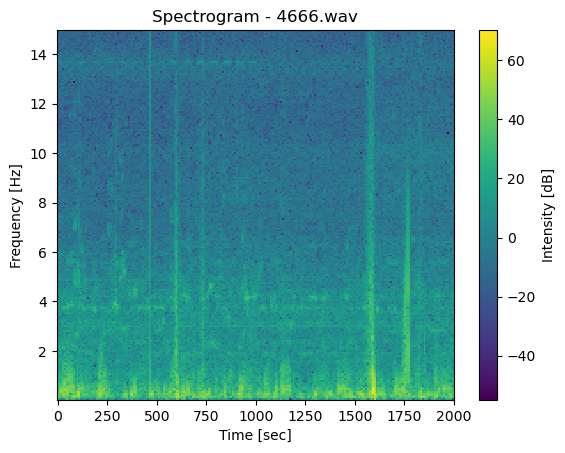

(7809, 1, 224, 224)


In [6]:
# Calculate FFT parameters for 224x224 spectrogram
nperseg, noverlap = fft_params(224, 224)
print("nperseg:", nperseg, "noverlap:", noverlap)

# Create spectrograms with calculated FFT parameters and plot the first spectrogram
all_spectrograms = make_spectrograms(nperseg, noverlap)

# Parse Labels Into Binary Encoded Matrix

In [8]:
def parse_labels(label_files, train_folder):
    binary_encoded_matrices = []

    for npy_file in label_files:
        npy_file_path = os.path.join(train_folder, npy_file)  # Correct path construction
        label_array = np.load(npy_file_path)  # Load the .npy file

        # Check the presence of wheeze, stridor, and rhonchi
        wheeze_present = label_array[0] == 1
        stridor_present = label_array[1] == 1
        rhonchi_present = label_array[2] == 1

        # Create a binary-encoded vector
        binary_code = 1 if wheeze_present or stridor_present or rhonchi_present else 0

        binary_encoded_matrices.append(binary_code)

    binary_encoded_matrix = np.array(binary_encoded_matrices).reshape(-1, 1)
    print(binary_encoded_matrix.shape)
    return binary_encoded_matrix

labels = parse_labels(label_files, train_folder)

(7809, 1)


# Datasets and Dataloaders

In [9]:
class CustomDataset(Dataset):
    def __init__(self, samples, labels):
        """
        Initialize the CustomDataset with paired samples.

        Args:
            samples (list of tuples): A list of (x, y) pairs representing the dataset samples.
        """
        self.samples = torch.Tensor(samples).to(torch.float32)
        self.labels = torch.Tensor(labels).to(torch.float32)

    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of samples.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns the sample pairs corresponding to the given list of indices.

        Args:
            indices (list): A list of indices to retrieve samples for.

        Returns:
            list: A list of (x, y) pairs corresponding to the specified indices.
        """
        selected_sample = self.samples[idx]
        selected_label = self.labels[idx]
        return selected_sample , selected_label

    def get_labels(self):
        """
        Returns the labels of the dataset.
        """
        return self.labels

In [10]:
# Create Train Dataset and Train Dataloader
batch_size = 32
train_dataset = CustomDataset(all_spectrograms, labels)
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size , shuffle=True)#, sampler=train_sampler)

TODO: Same as spectrograms, dataset and dataloader take a while to make, should we save to file?

# Model Definition: VGG16 CNN As Feature Extractors




In [11]:
class VGG16(nn.Module):
    def __init__(self, verbose=False):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc3 = nn.Linear(4096, 1)

        self.verbose = verbose

    def forward(self, x):
        if self.verbose:
            print(f"Input shape: {x.size()}")

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        if self.verbose:
            print(f"After Layer 1: {x.size()}")

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        if self.verbose:
            print(f"After Layer 2: {x.size()}")

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        if self.verbose:
            print(f"After Layer 3: {x.size()}")

        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)
        if self.verbose:
            print(f"After Layer 4: {x.size()}")

        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)
        if self.verbose:
            print(f"After Layer 5 {x.size()}")

        x = torch.flatten(x,1)
        #x = torch.unsqueeze(1,x)
        if self.verbose:
            print(f"Flattened: {x.size()}")

        x = F.relu(self.fc1(x))
        if self.verbose:
            print(f"After first Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = F.relu(self.fc2(x))
        if self.verbose:
            print(f"After Secound Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = self.fc3(x)
        x = torch.sigmoid(x)

        if self.verbose:
            print(f"Output shape: {x.size()}")

        return x

# GPU Setup

In [12]:
# gpu_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # Check for GPU
# print(gpu_device)  # Prints the device type
cpu_device = torch.device('cpu')  # Force using CPU

# Change this line to toggle CPU and GPU
device = cpu_device
print("Using Device:", device)

# Initialize VGG16 model and move it to the device (GPU if available)
print("Intermediate shapes for VGG16")
model = VGG16(verbose=True).to(device)

# Creating a dummy input tensor and moving it to the device
dummy_input = torch.ones(size=(1, 1, 224, 224)).to(device)

# Getting model output using the dummy input
output = model(dummy_input)

# # Additional GPU memory management
# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

Using Device: cpu
Intermediate shapes for VGG16
Input shape: torch.Size([1, 1, 224, 224])
After Layer 1: torch.Size([1, 64, 112, 112])
After Layer 2: torch.Size([1, 128, 56, 56])
After Layer 3: torch.Size([1, 256, 28, 28])
After Layer 4: torch.Size([1, 512, 14, 14])
After Layer 5 torch.Size([1, 512, 7, 7])
Flattened: torch.Size([1, 25088])
After first Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
After Secound Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
Output shape: torch.Size([1, 1])


# Training Loop Definition

In [13]:
def train_loop_bce(model, criterion, optimizer, n_epoch, n_batches, print_every):

    loss_hist = np.zeros(n_epoch * n_batches)
    precision_hist = np.zeros(n_epoch * n_batches)
    recall_hist = np.zeros(n_epoch * n_batches)
    f1_hist = np.zeros(n_epoch * n_batches)

    it = 0
    iter = 0
    for epoch in tqdm(range(n_epoch), desc="Epochs"):

        all_predictions = []
        all_labels = []

        for i, data in tqdm(enumerate(trainloader, 0), total=n_batches, desc="Mini Batches", leave=False):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Store predictions and labels for evaluation
            predictions = (outputs > 0.5).float()  # Convert to binary predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Print statistics
            loss_hist[iter] = loss.item()

            iter += 1

            if (i + 1) % print_every == 0:
                print('minibatch = {}/{}, loss = {}'.format(i + 1, n_batches, loss.item()))

        # Calculate precision, recall, and F1 score
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        precision = precision_score(all_labels, all_predictions, average='binary')
        recall = recall_score(all_labels, all_predictions, average='binary')
        f1 = f1_score(all_labels, all_predictions, average='binary')

        precision_hist[it] = precision
        recall_hist[it] = recall
        f1_hist[it] = f1

        print('epoch = {}/{}, Precision = {}, Recall = {}, F1 score = {}'.format(epoch + 1, n_epoch, precision, recall, f1))

        it += 1

    print("Finished Training")
    return loss_hist, precision_hist, recall_hist, f1_hist


# Hyperparameter Tuning

## Function Definitions

In [14]:
'''
Define objective function for hyperparameter tuning
Note: Optuna doesn't allow the objective function to have more than 1 parameter,
so we use a function to determine what metric we want to optimize,
then it returns the appropriate objective function
'''
def create_objective(metric='loss'):
    def objective(trial):
        # Suggest values for the hyperparameters
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
        weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)

        # Initialize model, criterion, and optimizer
        model = VGG16().to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Call training loop function
        n_epoch = 10
        n_batches = len(trainloader)
        print_every = 1
        loss_bce, precision_bce, recall_bce, f1_bce = train_loop_bce(model, criterion, optimizer, n_epoch, n_batches, print_every)

        # Select the metric to optimize
        metrics = {'loss': loss_bce, 'precision': precision_bce, 'recall': recall_bce, 'f1': f1_bce}
        selected_metric = np.mean(metrics[metric][-n_batches:])

        # For loss, minimize; for other metrics, maximize
        return selected_metric if metric == 'loss' else -selected_metric

    return objective

# Get optimization direction, since loss will always be minimized and everything else will be maximized
def get_opt_direction(metric):
    return 'minimize' if metric == 'loss' else 'maximize'

## Optuna Usage
- Range of Hyperparameter Values: Change values in trial.suggest_loguniform() to alter what range you want to explore for this hyperparameter
- Metric: Decide what metric is going to be optimized (f1, precision, recall, loss)

In [ ]:
# If we want to maximize f1 score
opt_metric = 'f1'  # Can be 'loss', 'precision', 'recall', or 'f1'
direction = get_opt_direction(opt_metric)
objective_function = create_objective(opt_metric)

# Create Optuna study and optimize for n_trials
study = optuna.create_study(direction=direction)
study.optimize(objective_function, n_trials=100)

# Best hyperparameters
print('Best trial:', study.best_trial.params)

[I 2023-12-03 11:41:07,638] A new study created in memory with name: no-name-b43f7e91-19d7-4f82-a286-2d4df0c65d41
/var/folders/5z/bq6w_3_93qj7g2fsm02th7nh0000gn/T/ipykernel_88272/1524754586.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/var/folders/5z/bq6w_3_93qj7g2fsm02th7nh0000gn/T/ipykernel_88272/1524754586.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
Epochs:   0%|          | 0/10 [00:45<?, ?it/s]
[W 2023-12-03 11:41:54,291] Trial 0 failed with parameters: {'learning_rate': 0.001941370500226309, 'weight_decay': 5.31

KeyboardInterrupt: 

## Regular Training (No Hyperparameter Tuning)

- Uncomment cell to run training loop without Optuna

In [16]:
# model = VGG16()#.to(device)
# criterion = nn.BCELoss()#pos_weight=class_weights_tensor)
# learning_rate = 0.01
# weight_decay = 1e-8
# optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
# n_epoch   = 10
# n_batches = len(trainloader)
# print_every = 1

# loss_bce, precision_bce, recall_bce, f1_bce = train_loop_bce(model,criterion,optimizer,n_epoch,n_batches,print_every)

Epochs:   0%|          | 0/10 [00:42<?, ?it/s]


KeyboardInterrupt: 

Plotting training losses

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(loss_hist, label = "TrainDatasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Training Loss')
axs[0].legend()


axs[1].plot(acc_hist, label = "TrainDatasets")
axs[1].set_ylabel('Accuracy [%]')
axs[1].set_xlabel('Iterations')
axs[1].legend()

Save the variable of training model for reusing purpose

In [ ]:
# Save all relevant information at the end of training
#Store_variable = {
 #   'model_state_dict': model.state_dict(),
 #   'optimizer_state_dict': optimizer.state_dict(),
 #   'loss_history': loss_hist,
 #   'accuracy_history': acc_hist,
 #   'train_dataset' : train_dataset,
 #   'test_dataset' : test_dataset,
 #   'trainloader' : trainloader,
 #   'testloader' : testloader,
#}

# Save the model to a file
torch.save({model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': loss_hist,
    'accuracy_history': acc_hist,
    'train_dataset' : train_dataset,
    'test_dataset' : test_dataset,
    'trainloader' : trainloader,
    'testloader' : testloader}, )
# Create a download link link from Jupyter Notebook
from IPython.display import FileLink
FileLink(Store_variable)

# Load the model from the file
model, optimizer, loss_history, accuracy_history, train_dataset,test_dataset,trainloader,testloader = torch.load(Store_variable).values()

Testing

In [ ]:
# Find accuracy over testing set

def find_vacc(net,loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += np.sum(predicted.cpu().numpy() == np.argmax(labels.numpy(), axis=1))
    vacc = 100.0 * correct / total
    return vacc

test_acc = find_vacc(model, testloader)

print(f'Accuracy of the network trained on the test images: {test_acc} %')